In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skradar
from scipy.stats import rayleigh

# Radar Settings
The following settings are similar as the ones in ```single_static_target.ipynb```. An important modification is the use of a boxcar window, as other windows would influence the CFAR behavior. See https://doi.org/10.1109/RadarConf.2015.7411889 for an analysis of this behavior.

In [2]:
B = 1e9
fc = 76.5e9
N_f = 512  # number of fast-time samples
fs_f = 1e6  # fast-time sampling rate
Ts_s = (N_f-1)/fs_f  # slow-time sampling interval
N_s = 1  # number of slow-time samples

tx_pos = np.array([[0], [0], [0]])
rx_pos = np.array([[0], [0], [0]])

radar_pos = np.array([[0], [0], [0]])
radar = skradar.FMCWRadar(B=B, fc=fc, N_f=N_f, T_f=1/fs_f, T_s=Ts_s,
                          N_s=N_s, tx_pos=tx_pos, rx_pos=rx_pos, tx_ant_gains = np.array([15]),
                          rx_ant_gains = np.array([10]), pos=radar_pos, win_range='boxcar', name='First radar',
                          if_real=True)

target_pos = np.array([[0], [11.3], [0]])
target = skradar.Target(rcs=10, pos=target_pos, name='Static target, 10 sqm')

scene = skradar.Scene([radar], [target])

# Radar Signal Simulation and Range Processing
Range compression is calculated without zeropadding (```zp_coarse = 1```) in order to avoid correlated samples along the range bins.

In [3]:
radar.sim_chirps()

zp_coarse = 1
radar.range_compression(zp_fact=zp_coarse)

rp_plot_noisy_coarse = 1/(np.sqrt(2))*radar.rp_noisy[0, 0, 0, :len(radar.ranges)//2]
target_dists_coarse = radar.ranges/2  # halve values to account for round-trip ranges
target_dists_plot_coarse = target_dists_coarse[:len(radar.ranges)//2]

Now the CFAR detector is configured and its threshold is calculated across all range bins.

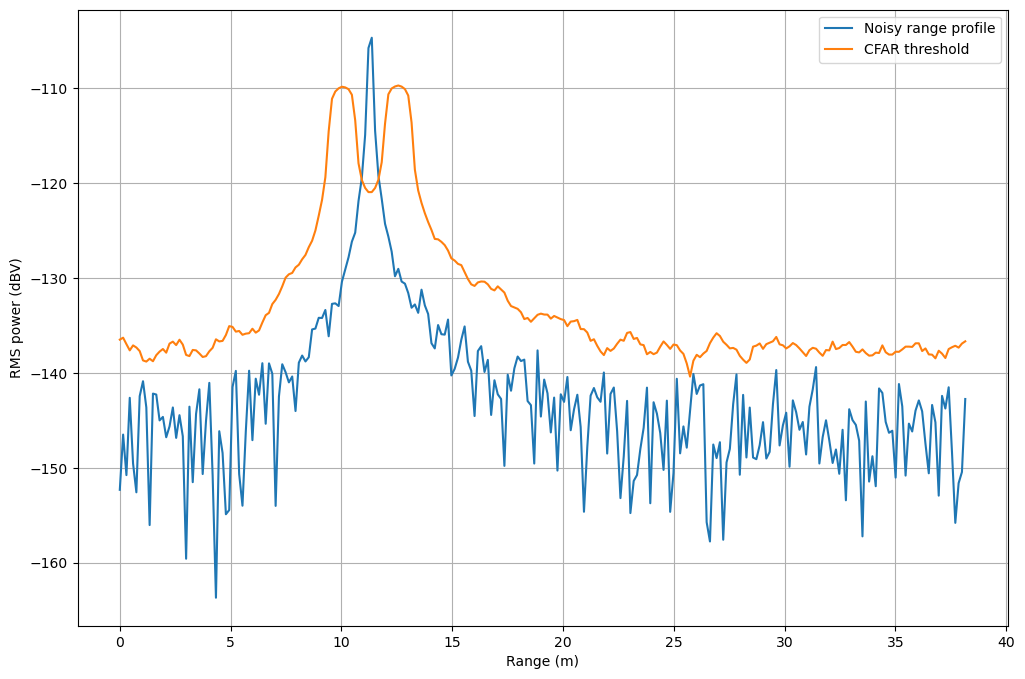

In [4]:
CFARConfig = skradar.detection.cfar.CFARConfig(train_cells=8*zp_coarse, guard_cells=4*zp_coarse,
                                               pfa=1e-2, mode=skradar.detection.cfar.CFARMode.CA)

threshold = skradar.detection.cfar.cfar_threshold(np.abs(rp_plot_noisy_coarse), cfg=CFARConfig)

plt.figure(2, figsize=(12, 8))
plt.clf()
plt.plot(target_dists_plot_coarse, 20*np.log10(np.abs(rp_plot_noisy_coarse)), label='Noisy range profile')
plt.plot(target_dists_plot_coarse, 20*np.log10(threshold), label='CFAR threshold');
plt.legend()
plt.grid(True)
plt.xlabel('Range (m)')
plt.ylabel('RMS power (dBV)');

# Monte Carlo Simulations
A Monte Carlo simulation is run for several values of the probability of false alarm. A signal without any target is simulated and a single range bin (cell under test, CUT) is used to determine the number of false alarms. The relative number of false alarms can then be compared to the simulated values of $P_{\mathrm{fa}}$.

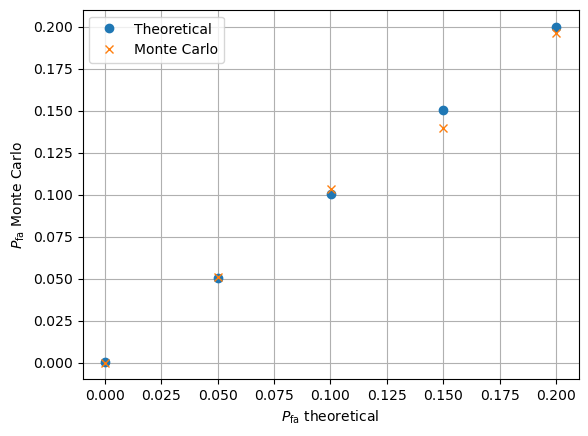

In [5]:
mc_runs = 1500  # number of Monte Carlo runs

pfa_desired = np.linspace(1e-4, 2e-1, 5)  # simulated pfa values
false_alarms = np.zeros(len(pfa_desired))  # initialize vector with number of detected false alarms

noise_collection = np.empty((len(pfa_desired), mc_runs, len(radar.ranges)//2), dtype=complex)
threshold_collection = np.empty((len(pfa_desired), mc_runs, len(radar.ranges)//2))

CUT_idx = 10
for pfa_cntr, pfa in enumerate(pfa_desired):
    for mc_cntr in range(mc_runs):
        radar.generate_AWGN()
        radar.range_compression(zp_fact=zp_coarse)
        # noise only signal
        rp_noisy = 1/(np.sqrt(2))*radar.rp_noisy[0, 0, 0, :len(radar.ranges)//2]
        noise_only = rp_noisy - 1/(np.sqrt(2))*radar.rp[0, 0, 0, :len(radar.ranges)//2]
        noise_collection[pfa_cntr, mc_cntr, :] = noise_only
        CFARConfig = skradar.detection.cfar.CFARConfig(train_cells=8*zp_coarse, guard_cells=4*zp_coarse, pfa=pfa)
        threshold = skradar.detection.cfar.cfar_threshold(np.abs(noise_only), cfg=CFARConfig)  #dc bin is problematic
        threshold_collection[pfa_cntr, mc_cntr, :] = threshold
        if np.abs(noise_only[CUT_idx]) > threshold[CUT_idx]:
            false_alarms[pfa_cntr] += 1

plt.plot(pfa_desired, pfa_desired, 'o', label='Theoretical');
plt.plot(pfa_desired, false_alarms/mc_runs, 'x', label='Monte Carlo');
plt.xlabel("$P_{\\mathrm{fa}}$ theoretical")
plt.ylabel("$P_{\\mathrm{fa}}$ Monte Carlo")
plt.legend()
plt.grid(True)

Now we can validate the CFAR threshold using histograms and cumulative probability densities. The histogram of the absolute value of a single (noise only) bin should follow a Rayleigh distribution. In the first plot we can see, that this is not true for range bin zero. Note that range bin zero is special, as we used a real-valued simulation for the IF signal of the FMCW radar.  
Nevertheless, the other range bins indeed follow the Rayleigh distribution. Therefore, the calculated threshold (which involves the sum of Rayleigh distributed values) is suitable to control $P_{\mathrm{fa}}$. This can be seen in the final CDF plots which include the threshold level and the value $1-P_{\mathrm{fa}}$. Even for range bin zero the threshold seems to be usable.

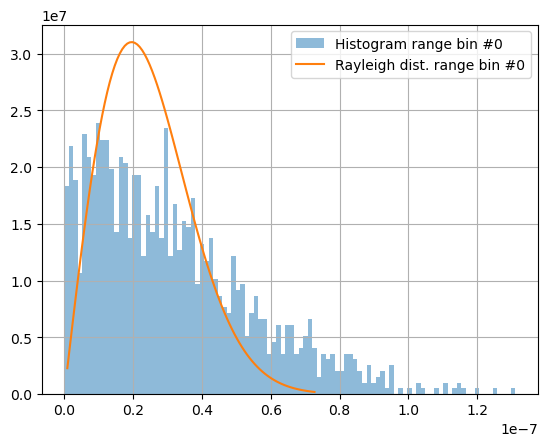

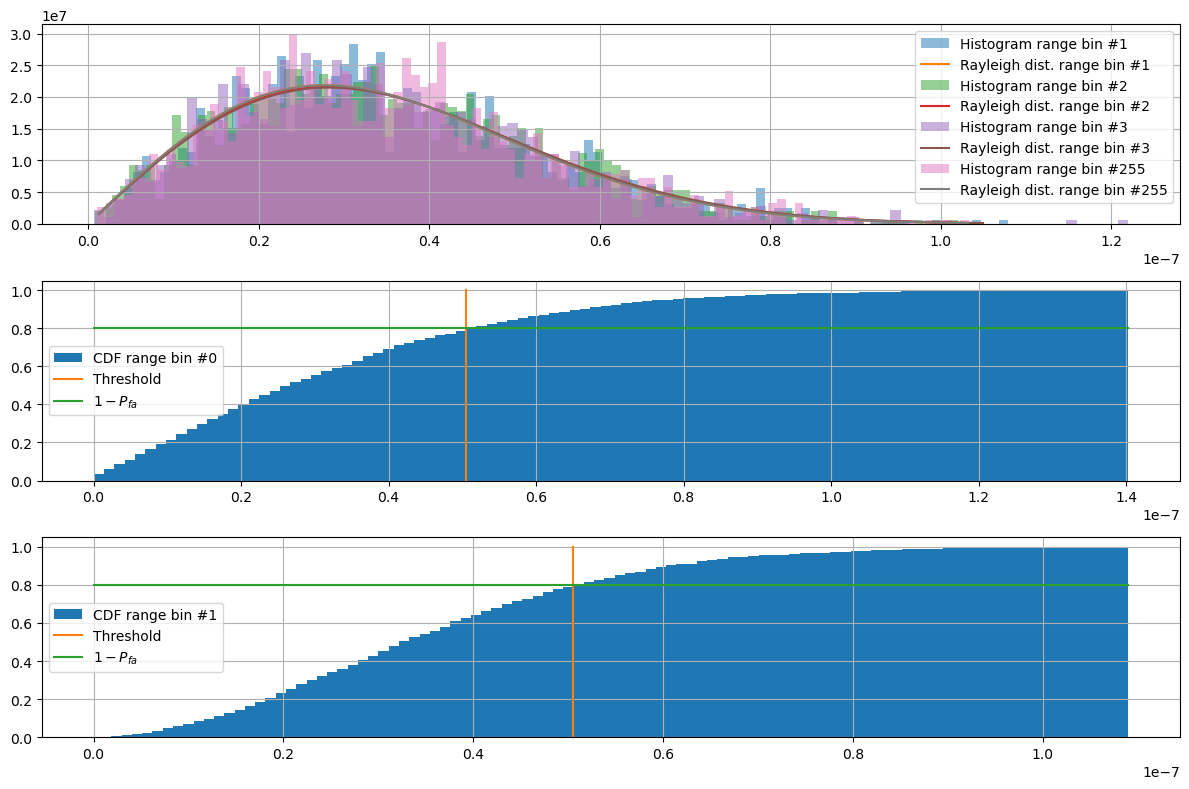

In [6]:
pfa_idx = len(pfa_desired)-1  # analyze the last simulated pfa value

plt.figure(3)
rangebin = 0
plt.hist(np.abs(noise_collection[pfa_idx, :, rangebin]), bins=100, density=True,
            alpha=0.5, label=f'Histogram range bin #{rangebin}');
noise_std_re = np.std(np.real(noise_collection[pfa_idx, :, rangebin]))
noise_std_im = np.std(np.imag(noise_collection[pfa_idx, :, rangebin]))
noise_std = (noise_std_re+noise_std_im)/2
x = np.linspace(rayleigh.ppf(0.001, loc=0, scale=noise_std),
            rayleigh.ppf(0.999, loc=0, scale=noise_std), 100)    
plt.plot(x, rayleigh.pdf(x, loc=0, scale=noise_std), label=f'Rayleigh dist. range bin #{rangebin}');
plt.legend()
plt.grid(True)

plt.figure(4, figsize=(12, 8))
plt.subplot(3,1,1)
for rangebin in list(range(1, 4))+[N_f//2-1]:
    plt.hist(np.abs(noise_collection[pfa_idx, :, rangebin]), bins=100, density=True,
             alpha=0.5, label=f'Histogram range bin #{rangebin}');
    noise_std_re = np.std(np.real(noise_collection[pfa_idx, :, rangebin]))
    noise_std_im = np.std(np.imag(noise_collection[pfa_idx, :, rangebin]))
    noise_std = (noise_std_re+noise_std_im)/2
    x = np.linspace(rayleigh.ppf(0.001, loc=0, scale=noise_std),
                rayleigh.ppf(0.999, loc=0, scale=noise_std), 100)    
    plt.plot(x, rayleigh.pdf(x, loc=0, scale=noise_std), label=f'Rayleigh dist. range bin #{rangebin}');
plt.legend()

T = np.mean(threshold_collection[pfa_idx, mc_cntr, :])
plt.grid(True)
plt.subplot(3,1,2)
rangebin = 0
_, x, _ = plt.hist(np.abs(noise_collection[0, :, rangebin]), bins=100, density=True, cumulative=True, label=f"CDF range bin #{rangebin}");
plt.plot((T, T), (0, 1), label="Threshold");
plt.plot((0, np.max(x)), (1-pfa_desired[pfa_idx], 1-pfa_desired[pfa_idx]), label="$1-P_{fa}$")
plt.grid(True)
plt.legend();
plt.tight_layout()
plt.subplot(3,1,3)
rangebin = 1
_, x, _ = plt.hist(np.abs(noise_collection[0, :, rangebin]), bins=100, density=True, cumulative=True, label=f"CDF range bin #{rangebin}");
plt.plot((T, T), (0, 1), label="Threshold");
plt.plot((0, np.max(x)), (1-pfa_desired[pfa_idx], 1-pfa_desired[pfa_idx]), label="$1-P_{fa}$")
plt.grid(True)
plt.legend();
plt.tight_layout()